In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import sys

# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import utils
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [2]:
def eliminate_features(classifier, X, y ):
    iteration = 0
    print("Iteration= ", iteration)
    iteration += 1
    model_stats = {}
    drop_list = []
    # get baseline by identifying sorted important features using all of the provided features
    model_stats = utils.save_model_stats(classifier,X,y,model_stats)
    
    important_features = utils.display_important_features(classifier.feature_importances_, X,0)
    # least important feature
    least_important_label = important_features[-1][0]
    print("least_important label= ", least_important_label)
    
    drop_list.append(least_important_label)
    del important_features[-1]
    
    # drop list contains all of the feature labels except for the feature label identified as being most important
    list_count = len(important_features)
    while list_count > 0:
        print("Iteration= ", iteration)
        iteration += 1
        model_stats = utils.save_model_stats(classifier,X.drop(columns=drop_list),y,model_stats)
        least_important_label = important_features[-1][0]
        print("least_important label= ", least_important_label)
        drop_list.append(least_important_label)
        del important_features[-1]
        list_count-=1
    return model_stats


#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

In [3]:
summary_data = pd.read_csv(Path( '../Data/sr_summaries_kaggle_id.csv'))
print(summary_data.shape)

#display rows with NaNs
summary_data[summary_data.isnull().any(axis=1)]

(2773, 22)


,season,School,team_id,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,allow_fg_pct,ft_pct,allow_ft_att_avg,poss_avg,off_rebs_avg,allow_off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
38,2009,Centenary (LA),NaN,29,-17.16,-5.08,0.276,70,80,0.416,0.49,0.733,25,80.641379,9,11,20,27,15,7,86.804071,21


In [4]:
#drop records with NaNs
summary_data.dropna(inplace=True)
print(summary_data.shape)

(2772, 22)


In [5]:
summary_data.rename(str.lower, axis='columns', inplace=True)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,allow_fg_pct,ft_pct,allow_ft_att_avg,poss_avg,off_rebs_avg,allow_off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2009,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,31,-4.90,3.13,0.323,57,63,0.443,0.451,0.635,19,65.535484,7,8,20,22,12,5,86.975783,16
1,2009,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,35,2.82,-1.50,0.686,70,65,0.433,0.417,0.657,21,79.485714,13,11,22,22,13,6,88.066139,21
2,2009,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,32,10.34,6.62,0.531,68,64,0.441,0.424,0.707,19,76.562500,12,12,23,22,12,7,88.816327,19
3,2009,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,27,-20.19,-13.71,0.407,65,69,0.382,0.424,0.635,24,85.525926,13,15,23,27,16,9,76.000346,27
4,2009,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-14.41,-12.02,0.516,64,65,0.404,0.435,0.641,24,78.954839,12,10,22,23,16,7,81.058997,23


#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [6]:
# Read table of team names and associated team meta data
teams = pd.read_csv(Path('../Data/D1_teams.csv'))
teams.drop(columns=['code_ncaa','school_ncaa','turner_name','league_name','league_alias','conf_alias',
                    'conf_id','division_name','division_alias','division_id',
                    'kaggle_team_id','venue_id'], inplace=True)
teams.info()
teams.set_index('id',inplace=True)
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
id           351 non-null object
conf_name    351 non-null object
dtypes: object(2)
memory usage: 5.6+ KB


,conf_name
id,
fe406882-9f22-495e-9df6-ef357a6803c6,Ivy
ca478771-aa3d-4231-81e0-b70f519134fb,Ivy
5c7bf63f-bc39-43c5-9907-73b50b7a6b34,Ivy
d60357bd-1205-42e9-9092-d986a2843a34,Ivy
88ff8c00-958e-4ccf-a21d-77fab9e93692,Ivy


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [7]:
tourney_data = pd.read_csv(Path('../Data/tournament_results.csv'))
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)



tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 9 columns):
season          2117 non-null int64
round           2117 non-null int64
game_date       2117 non-null object
win_seed        2117 non-null int64
win_market      2117 non-null object
win_team_id     2117 non-null object
lose_seed       2117 non-null int64
lose_market     2117 non-null object
lose_team_id    2117 non-null object
dtypes: int64(4), object(5)
memory usage: 148.9+ KB


In [8]:
game_data = tourney_data.join(teams, on='win_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'win_kaggle_team_id','conf_name':'win_conf_name'}, inplace=True)
game_data = game_data.join(teams,on='lose_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'lose_kaggle_team_id','conf_name':'lose_conf_name'}, inplace=True)
games_won_conf = game_data.groupby('win_conf_name').size().reset_index(name='count').sort_values(by=['count'], ascending=False)

games_won_conf['percent'] = 100 * games_won_conf['count']/games_won_conf['count'].sum()
games_won_conf['cum_percent'] = games_won_conf['percent'].cumsum()
games_won_conf.head()

,win_conf_name,count,percent,cum_percent
3,Atlantic Coast,431,20.358999,20.358999
9,Big Ten,313,14.785073,35.144072
24,Southeastern,269,12.706660,47.850732
5,Big 12,231,10.911667,58.762400
22,Pacific 12,197,9.305621,68.068021


Identify the conferences that have won 70% of all conference games

In [9]:
top_tournament_conferences_list = games_won_conf[games_won_conf['cum_percent']<= 70]['win_conf_name'].tolist()
top_tournament_conferences_list

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']

The summary season data in this set goes back to 2010. If more training data is needed we can go back to earlier seasons.

So the intersection of season summary data with tournament data are regular seasons 2010 through 2016.

In [10]:
tourney_data = tourney_data[tourney_data['season'] >= 2010]
tourney_data.describe()['season']

count     533.000000
mean     2013.519700
std         2.284733
min      2010.000000
25%      2012.000000
50%      2014.000000
75%      2016.000000
max      2017.000000
Name: season, dtype: float64

In [11]:
# recode the tourney data so that the teams are not marked with  win/lose status and the game result is encoded as a binary
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1

#create some temporary buffer columns
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id'],inplace=True)
tourney_data.rename(columns={"team_seed":"seed_t","opp_team_seed":"seed_o"}, inplace=True)

tourney_data['Game Result'] = tourney_data.game_result.map({1:'Win', 0:'Lose'})
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','team_id'], 
                                right_on=['season', 'team_id'],how='left',suffixes=('','_y'))

tourney_data.drop(columns=['season_y'],inplace=True)
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','opp_team_id'], 
                                right_on=['season', 'team_id'], how='left',suffixes=('_t','_o'))

tourney_data.drop(columns=['school_t','school_o','games_t','games_o','team_id_o'],inplace=True)

tourney_data = tourney_data.join(teams, on='team_id_t', how='left')
tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
tourney_data.rename(index=str,columns={'team':'team_t','opp_team':'team_o', 'opp_team_id':'team_id_o'},inplace=True)

tourney_data['game_result'] = tourney_data.game_result.apply(utils.negate_loser)
tourney_data.head()



,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10


In [12]:
computer_rankings = pd.read_csv(Path( '../Data/massey_seasons_with_id.csv'))
computer_rankings = computer_rankings[computer_rankings['season']>=2010]
computer_rankings[computer_rankings.isnull().any(axis=1)]

,SAG,WLK,WOL,Team,RTH,COL,POM,DOL,RPI,MOR,season,win_pct,kaggle_id


In [13]:
temp_merge = tourney_data.merge(computer_rankings, left_on=['season_t','team_id_t'], 
                                right_on=['season', 'kaggle_id'],how='left',suffixes=('','_y'))

temp_merge.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)
temp_merge.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG,WLK,WOL,RTH,COL,POM,DOL,RPI,MOR
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3


In [14]:
tourney_comp_ratings = temp_merge.merge(computer_rankings,left_on=['season_t','team_id_o'], 
                                right_on=['season', 'kaggle_id'], how='left',suffixes=('_t','_o'))

tourney_comp_ratings.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)

tourney_comp_ratings.rename(str.lower, axis='columns', inplace=True)
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80


#### Add a feature
top_conf = 1 if team is a top conference and opponent is not
top_conf = -1 if opp_team is a top_conference and team is not
top_conf = 0 otherwise

In [15]:
print(top_tournament_conferences_list)
tourney_comp_ratings['top_conf'] = tourney_comp_ratings.apply(lambda row: utils.conf_compare(row.conf_name_t, 
                                                                                             row.conf_name_o,
                                                                                             top_tournament_conferences_list),
                                                              axis=1)

tourney_comp_ratings.head(10)[['game_result','conf_name_t','conf_name_o','top_conf']]

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']


,game_result,conf_name_t,conf_name_o,top_conf
0,-1,Atlantic Coast,American Athletic,1
1,1,American Athletic,Big Ten,-1
2,-1,Mid-American,Atlantic 10,0
3,1,Atlantic 10,American Athletic,0
4,-1,Big 12,Atlantic 10,1
5,1,Atlantic 10,Atlantic Coast,-1
6,-1,Big Ten,Atlantic 10,1
7,1,Atlantic 10,Big East,0
8,-1,Pacific 12,Atlantic 10,1
9,1,Atlantic 10,Pacific 12,-1


In [16]:
# Upsets occur less than 30% of the time when seeding deltas are more than 6
tourney_comp_ratings['upset_seed_threshold'] = tourney_comp_ratings.apply(
    lambda row: abs(row.seed_t - row.seed_o) > 6, axis=1).astype(int)
    
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1


In [17]:
tourney_comp_ratings['margin_victory_avg_t'] = tourney_comp_ratings['pts_avg_t'] - tourney_comp_ratings['opp_pts_avg_t']
tourney_comp_ratings['margin_victory_avg_o'] = tourney_comp_ratings['pts_avg_o'] - tourney_comp_ratings['opp_pts_avg_o']

tourney_comp_ratings['delta_margin_victory_avg'] = tourney_comp_ratings['margin_victory_avg_t'] - \
    tourney_comp_ratings['margin_victory_avg_o']

tourney_comp_ratings['delta_fg_pct'] = tourney_comp_ratings['fg_pct_t'] - tourney_comp_ratings['fg_pct_o']

#tourney_comp_ratings['allow_fg_pct'] = tourney_comp_ratings['allow_fg_pct_t'] - tourney_comp_ratings['allow_fg_pct_o']
tourney_comp_ratings['delta_off_rebs_avg'] = tourney_comp_ratings['off_rebs_avg_t'] - tourney_comp_ratings['off_rebs_avg_o']

tourney_comp_ratings['delta_def_rebs_avg'] = tourney_comp_ratings['def_rebs_avg_t'] - tourney_comp_ratings['def_rebs_avg_o']

tourney_comp_ratings['delta_allow_def_rebs_avg'] = tourney_comp_ratings['allow_def_rebs_avg_t'] - \
    tourney_comp_ratings['allow_def_rebs_avg_o']

tourney_comp_ratings['delta_ft_pct'] = tourney_comp_ratings['ft_pct_t'] - tourney_comp_ratings['ft_pct_o']

tourney_comp_ratings['to_net_avg_t'] = tourney_comp_ratings['to_avg_t'] - tourney_comp_ratings['steal_avg_t']

tourney_comp_ratings['to_net_avg_o'] = tourney_comp_ratings['to_avg_o'] - tourney_comp_ratings['steal_avg_o']

tourney_comp_ratings['delta_to_net_avg'] = tourney_comp_ratings['to_net_avg_t'] - tourney_comp_ratings['to_net_avg_o']

tourney_comp_ratings['delta_win_pct'] = tourney_comp_ratings['win_pct_t'] - tourney_comp_ratings['win_pct_o']

tourney_comp_ratings['delta_off_rating'] = tourney_comp_ratings['off_rating_t'] - tourney_comp_ratings['off_rating_o']

tourney_comp_ratings['delta_allow_off_rebs_avg'] = tourney_comp_ratings['allow_off_rebs_avg_t'] - \
    tourney_comp_ratings['allow_off_rebs_avg_o']

tourney_comp_ratings['delta_ft_att_avg'] = tourney_comp_ratings['ft_att_avg_t'] - tourney_comp_ratings['ft_att_avg_o']

tourney_comp_ratings['delta_allow_ft_att_avg'] = tourney_comp_ratings['allow_ft_att_avg_t'] -  \
    tourney_comp_ratings['allow_ft_att_avg_o']

tourney_comp_ratings['delta_seed'] = tourney_comp_ratings['seed_t'] - tourney_comp_ratings['seed_o']

tourney_comp_ratings['delta_srs'] = tourney_comp_ratings['srs_t'] - tourney_comp_ratings['srs_o']
tourney_comp_ratings['delta_sos'] = tourney_comp_ratings['sos_t'] - tourney_comp_ratings['sos_o']

tourney_comp_ratings['delta_sag'] = tourney_comp_ratings['sag_t'] - tourney_comp_ratings['sag_o']
tourney_comp_ratings['delta_wlk'] = tourney_comp_ratings['wlk_t'] - tourney_comp_ratings['wlk_o']
tourney_comp_ratings['delta_wol'] = tourney_comp_ratings['wol_t'] - tourney_comp_ratings['wol_o']
tourney_comp_ratings['delta_rth'] = tourney_comp_ratings['rth_t'] - tourney_comp_ratings['rth_o']
tourney_comp_ratings['delta_col'] = tourney_comp_ratings['col_t'] - tourney_comp_ratings['col_o']
tourney_comp_ratings['delta_pom'] = tourney_comp_ratings['pom_t'] - tourney_comp_ratings['pom_o']
tourney_comp_ratings['delta_dol'] = tourney_comp_ratings['dol_t'] - tourney_comp_ratings['dol_o']
tourney_comp_ratings['delta_rpi'] = tourney_comp_ratings['rpi_t'] - tourney_comp_ratings['rpi_o']
tourney_comp_ratings['delta_mor'] = tourney_comp_ratings['mor_t'] - tourney_comp_ratings['mor_o']


tourney_comp_ratings.drop(columns=['season_o'], inplace=True)


In [18]:
feature_data = tourney_comp_ratings.drop(columns=['round','game_date','seed_t','team_t','team_id_t','team_id_o',
                                         'team_o','seed_o','team_id_o','game_result','start_season','game result',
                                         'conf_name_t','conf_name_o']).copy()


feature_data.head()

,season_t,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0,7,5,2,0.068,0,3,-4,-0.042,6,3,3,-0.020,5.261076,2,3,-1,-1,4.80,1.97,-30,-31.0,1,-19,-8.0,-33.0,-13.0,-8.0,-28
1,2011,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0,8,1,7,0.008,2,3,-1,-0.026,4,6,-2,0.206,0.300109,3,3,-2,-3,0.37,-7.22,-13,-12.0,-18,-5,-12.0,-1.0,-14.0,-9.0,18
2,2013,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1,9,12,-3,0.005,-1,3,-2,-0.058,6,0,6,0.038,-3.771096,-1,2,-1,7,-8.78,-4.29,36,36.0,25,32,23.0,33.0,15.0,18.0,44
3,2012,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,9,15,-6,-0.072,2,-6,3,-0.063,1,6,-5,-0.012,-10.243325,1,1,0,7,-8.63,-3.17,40,33.0,16,38,24.0,37.0,18.0,26.0,45
4,2011,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1,17,5,12,0.074,1,6,-3,-0.036,6,3,3,0.221,6.725684,0,2,0,-10,15.54,3.84,-75,-53.0,-51,-72,-58.0,-81.0,-70.0,-48.0,-77


In [19]:
feature_data.drop(columns=['pts_avg_t','pts_avg_o', 'opp_pts_avg_t','opp_pts_avg_o',
                                'margin_victory_avg_t', 'margin_victory_avg_o',
                                'poss_avg_t','poss_avg_o',
                                'fg_pct_t','fg_pct_o','allow_fg_pct_t','allow_fg_pct_o',
                                'off_rebs_avg_t','off_rebs_avg_o','def_rebs_avg_t','def_rebs_avg_o',
                                'allow_def_rebs_avg_t','allow_def_rebs_avg_o','ft_pct_t','ft_pct_o',
                                'to_avg_t','to_avg_o','steal_avg_t','steal_avg_o',
                                'to_net_avg_t','to_net_avg_o',
                                'win_pct_t','win_pct_o','off_rating_t','off_rating_o',
                                'allow_off_rebs_avg_t','allow_off_rebs_avg_o',
                                'ft_att_avg_t','ft_att_avg_o','opp_pts_avg_t','opp_pts_avg_o',
                                'srs_t','srs_o','sos_t','sos_o',
                                'allow_ft_att_avg_t','allow_ft_att_avg_o',
                                'sag_t','sag_o','wlk_t','wlk_o','wol_t','wol_o',
                                'rth_t','rth_o','col_t','col_o','pom_t','pom_o',
                                'dol_t','dol_o','rpi_t','rpi_o','mor_t','mor_o'], inplace=True)




feature_data.head()

,season_t,top_conf,upset_seed_threshold,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,1,0,2,0.068,0,3,-4,-0.042,3,-0.020,5.261076,2,3,-1,-1,4.80,1.97,-30,-31.0,1,-19,-8.0,-33.0,-13.0,-8.0,-28
1,2011,-1,0,7,0.008,2,3,-1,-0.026,-2,0.206,0.300109,3,3,-2,-3,0.37,-7.22,-13,-12.0,-18,-5,-12.0,-1.0,-14.0,-9.0,18
2,2013,0,1,-3,0.005,-1,3,-2,-0.058,6,0.038,-3.771096,-1,2,-1,7,-8.78,-4.29,36,36.0,25,32,23.0,33.0,15.0,18.0,44
3,2012,0,1,-6,-0.072,2,-6,3,-0.063,-5,-0.012,-10.243325,1,1,0,7,-8.63,-3.17,40,33.0,16,38,24.0,37.0,18.0,26.0,45
4,2011,1,1,12,0.074,1,6,-3,-0.036,3,0.221,6.725684,0,2,0,-10,15.54,3.84,-75,-53.0,-51,-72,-58.0,-81.0,-70.0,-48.0,-77


In [20]:
X= feature_data[feature_data['season_t']>=2010]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']>=2010]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['top_conf',
 'upset_seed_threshold',
 'delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_allow_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_allow_off_rebs_avg',
 'delta_ft_att_avg',
 'delta_allow_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(426, 26)
(426,)
(107, 26)
(107,)


,top_conf,upset_seed_threshold,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
140,0,1,2,0.069,-2,-2,-6,-0.008,2,0.081,5.170601,-1,-4,-2,-11,12.47,9.59,-101,-82.0,-105,-107,-94.0,-89.0,-110.0,-88.0,-94
293,0,0,-3,0.000,1,0,-4,-0.044,3,0.030,-5.202764,-4,0,-1,1,-2.42,0.22,10,14.0,5,3,3.0,14.0,1.0,4.0,8
368,-1,1,-4,0.032,-3,1,-1,0.016,2,-0.132,4.187608,0,-7,1,9,-14.49,-8.53,82,88.0,90,101,92.0,76.0,98.0,67.0,90
53,1,1,5,-0.006,7,3,-1,-0.085,0,0.118,-4.527964,1,5,5,-8,9.67,4.01,-56,-71.0,-63,-71,-74.0,-60.0,-68.0,-53.0,-54
33,0,0,1,-0.007,-1,0,-1,0.034,-1,-0.015,-0.684009,-1,-1,-3,2,-2.73,-3.85,7,9.0,3,8,5.0,6.0,10.0,6.0,16


#### Baseline Model

In [22]:
number_estimators = 401

bdt= AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME.R", n_estimators=number_estimators)
    
bdt.fit(X_train, y_train)
score = bdt.score(X_train, y_train)
print("Training Model Score= ", score)


Training Model Score=  1.0


In [23]:

important_features = utils.display_important_features( bdt.feature_importances_, X_train)

Coefficient Values
delta_win_pct   0.14214463840399003
delta_sos   0.14214463840399003
delta_fg_pct   0.07231920199501247
delta_ft_pct   0.06483790523690773
delta_dol   0.06234413965087282
delta_rth   0.059850374064837904
delta_srs   0.05486284289276808
delta_mor   0.04987531172069826
delta_wlk   0.03740648379052369
delta_rpi   0.03740648379052369
delta_pom   0.032418952618453865
delta_seed   0.029925187032418952
delta_sag   0.029925187032418952
delta_allow_def_rebs_avg   0.022443890274314215
delta_off_rating   0.022443890274314215
delta_allow_off_rebs_avg   0.0199501246882793
delta_ft_att_avg   0.0199501246882793
delta_wol   0.0199501246882793
delta_col   0.0199501246882793
delta_margin_victory_avg   0.014962593516209476
delta_def_rebs_avg   0.012468827930174564
delta_to_net_avg   0.012468827930174564
delta_allow_ft_att_avg   0.00997506234413965
delta_off_rebs_avg   0.007481296758104738
top_conf   0.0024937655860349127
upset_seed_threshold   0.0


In [24]:
y_pred = bdt.predict(X_test)
print("RF model accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

RF model accuracy is 0.72


array([[41, 11],
       [19, 36]], dtype=int64)

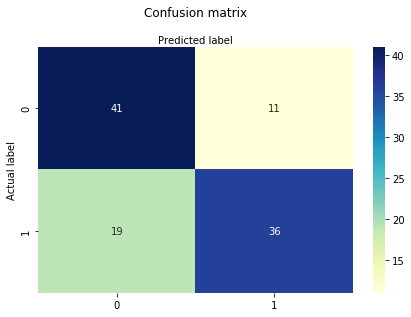

In [25]:
utils.display_confusion_matrix(y_test, y_pred)

##### Baseline Confusion Matrix

In [26]:
prediction_probabilities = bdt.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.719626168224299
Precision: 0.7659574468085106
Recall: 0.6545454545454545
Log loss=  0.6807683378751304


In [27]:
cross_val_scores = cross_val_score(bdt, X,y, cv=10, scoring='accuracy')
print("Baseline Cross Validation average= ",cross_val_scores.mean())

Baseline Cross Validation average=  0.7603330108047089


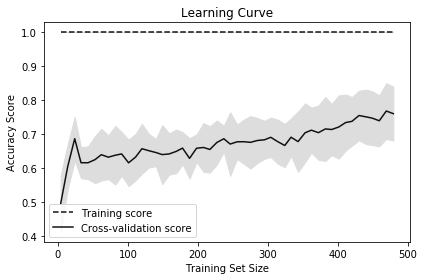

In [28]:
train_sizes, train_scores, test_scores = learning_curve(bdt, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

                   Baseline Learning Curve

#### Model Feature Optimization

In [30]:
X = feature_data[feature_data['season_t']>=2010]
X = X.drop(columns=['season_t'])
y = tourney_comp_ratings[tourney_comp_ratings['season_t']>=2010]['game_result']

model_stats = eliminate_features(bdt, X,y)


Iteration=  0
least_important label=  upset_seed_threshold
Iteration=  1
least_important label=  top_conf
Iteration=  2
least_important label=  delta_off_rebs_avg
Iteration=  3
least_important label=  delta_allow_ft_att_avg
Iteration=  4
least_important label=  delta_to_net_avg
Iteration=  5
least_important label=  delta_def_rebs_avg
Iteration=  6
least_important label=  delta_margin_victory_avg
Iteration=  7
least_important label=  delta_col
Iteration=  8
least_important label=  delta_wol
Iteration=  9
least_important label=  delta_ft_att_avg
Iteration=  10
least_important label=  delta_allow_off_rebs_avg
Iteration=  11
least_important label=  delta_off_rating
Iteration=  12
least_important label=  delta_allow_def_rebs_avg
Iteration=  13
least_important label=  delta_sag
Iteration=  14
least_important label=  delta_seed
Iteration=  15
least_important label=  delta_pom
Iteration=  16
least_important label=  delta_rpi
Iteration=  17
least_important label=  delta_wlk
Iteration=  18
least

In [31]:
max_accuracy = 0
max_cross_val = 0
min_log_loss = 10000
for key, value in model_stats.items():
    accuracy = value['accuracy']
    cross_val = value['cross_validation']
    log_loss_val = value['log_loss']
    print('Accuracy= {0:6.4f} Cross Val= {1:6.4f}  Log Loss= {2:6.4f}'.format(accuracy ,cross_val, log_loss_val ))
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        accuracy_hash = key
    if cross_val > max_cross_val:
        max_cross_val = cross_val
        cross_hash = key
    if log_loss_val < min_log_loss:
        min_log_loss = log_loss_val
        log_hash = key

print("\n")

print('Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['accuracy']))
print('Max Cross Validation= {0:6.4f}'.format( model_stats[cross_hash]['cross_validation']))
print ("Minimum Log Loss= {0:6.4f}".format(  model_stats[log_hash]['log_loss']))
print('Log Loss at Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['log_loss'] ))
print('Log Loss at Max Cross Validation= {0:6.4f} '.format( model_stats[cross_hash]['log_loss'] ))

Accuracy= 0.7196 Cross Val= 0.7622  Log Loss= 0.6808
Accuracy= 0.7196 Cross Val= 0.7603  Log Loss= 0.6808
Accuracy= 0.7196 Cross Val= 0.7567  Log Loss= 0.6804
Accuracy= 0.7009 Cross Val= 0.7471  Log Loss= 0.6834
Accuracy= 0.6916 Cross Val= 0.7285  Log Loss= 0.6829
Accuracy= 0.6822 Cross Val= 0.7453  Log Loss= 0.6830
Accuracy= 0.6916 Cross Val= 0.7550  Log Loss= 0.6828
Accuracy= 0.6916 Cross Val= 0.7565  Log Loss= 0.6823
Accuracy= 0.7009 Cross Val= 0.7547  Log Loss= 0.6832
Accuracy= 0.7009 Cross Val= 0.7622  Log Loss= 0.6833
Accuracy= 0.6822 Cross Val= 0.7586  Log Loss= 0.6827
Accuracy= 0.6822 Cross Val= 0.7473  Log Loss= 0.6833
Accuracy= 0.7290 Cross Val= 0.7625  Log Loss= 0.6830
Accuracy= 0.7383 Cross Val= 0.7905  Log Loss= 0.6828
Accuracy= 0.7290 Cross Val= 0.7661  Log Loss= 0.6823
Accuracy= 0.7383 Cross Val= 0.7867  Log Loss= 0.6824
Accuracy= 0.7009 Cross Val= 0.7886  Log Loss= 0.6827
Accuracy= 0.7383 Cross Val= 0.7753  Log Loss= 0.6821
Accuracy= 0.7570 Cross Val= 0.7755  Log Loss= 

In [32]:
model_features = model_stats[cross_hash]['labels']
print(model_features)

['delta_fg_pct', 'delta_ft_pct', 'delta_win_pct', 'delta_seed', 'delta_srs', 'delta_sos', 'delta_sag', 'delta_wlk', 'delta_rth', 'delta_pom', 'delta_dol', 'delta_rpi', 'delta_mor']


In [33]:
X = feature_data[feature_data['season_t']>=2010][model_features]


array([[39, 13],
       [15, 40]], dtype=int64)

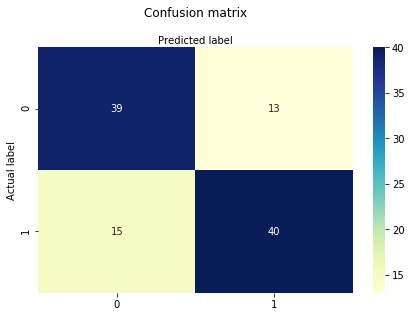

In [34]:
y = tourney_comp_ratings[tourney_comp_ratings['season_t']>=2010]['game_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
bdt.fit(X_train, y_train)
y_pred = bdt.predict(X_test)
# save model stats
prediction_probabilities = bdt.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
log_loss_value = log_loss(y_test, prediction_probabilities)
cross_val_scores = cross_val_score(bdt, X,y, cv=10, scoring='accuracy')
cross_validation_average = cross_val_scores.mean()

train_sizes, train_scores, test_scores = learning_curve(bdt, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
utils.display_confusion_matrix(y_test, y_pred)



In [35]:
utils.display_important_features( bdt.feature_importances_, X_train)

Coefficient Values
delta_sos   0.14962593516209477
delta_win_pct   0.1396508728179551
delta_srs   0.08478802992518704
delta_dol   0.08229426433915212
delta_ft_pct   0.0798004987531172
delta_fg_pct   0.0773067331670823
delta_rth   0.0773067331670823
delta_rpi   0.07231920199501247
delta_wlk   0.06234413965087282
delta_mor   0.06234413965087282
delta_pom   0.04738154613466334
delta_seed   0.03740648379052369
delta_sag   0.02743142144638404


[('delta_sos', 0.14962593516209477),
 ('delta_win_pct', 0.1396508728179551),
 ('delta_srs', 0.08478802992518704),
 ('delta_dol', 0.08229426433915212),
 ('delta_ft_pct', 0.0798004987531172),
 ('delta_fg_pct', 0.0773067331670823),
 ('delta_rth', 0.0773067331670823),
 ('delta_rpi', 0.07231920199501247),
 ('delta_wlk', 0.06234413965087282),
 ('delta_mor', 0.06234413965087282),
 ('delta_pom', 0.04738154613466334),
 ('delta_seed', 0.03740648379052369),
 ('delta_sag', 0.02743142144638404)]

In [36]:
prediction_probabilities = bdt.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.7383177570093458
Precision: 0.7547169811320755
Recall: 0.7272727272727273
Log loss=  0.6828013056072104


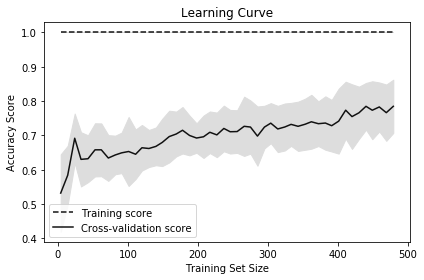

In [37]:
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [38]:
# Retrieve the non-normalized game stats
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_test.index)].copy()

test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs

#test_games['game_result'] = test_games.game_result.apply(negate_loser)

test_games.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob
7,2011,64,2011-03-18,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,6,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,1,2010,Win,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,14.61,10.39,0.656,70,66,0.475,0.387,0.734,19,73.850000,10,10,23,19,13,6,94.786730,17,Atlantic 10,Big East,77,55.0,54,74,59.0,84.0,72.0,49.0,80,16,19.0,16,17,16.0,31.0,19.0,13.0,42,0,0,5,4,1,-0.041,0,-2,5,-0.019,3,7,-4,0.044,-0.422030,0,3,-1,5,-6.05,-6.61,61,36.0,38,57,43.0,53.0,53.0,36.0,38,1,0.502663
28,2012,64,2012-03-16,5,Temple,8598d1b6-106b-4083-a512-2e495729525a,12,South Florida,55af9c69-3675-4b9b-a882-96640b782fff,-1,2011,Lose,10.44,4.94,0.750,75,69,0.469,0.435,0.719,19,77.743750,10,11,21,22,12,7,96.470777,19,9.20,7.29,0.611,59,56,0.437,0.386,0.705,16,69.133333,10,10,20,20,13,5,85.342334,16,American Athletic,American Athletic,36,29.0,28,35,22.0,34.0,20.0,20.0,42,70,51.0,60,53,59.0,66.0,60.0,52.0,47,0,1,6,3,3,0.032,0,1,2,0.014,5,8,-3,0.139,11.128444,1,3,3,-7,1.24,-2.35,-34,-22.0,-32,-18,-37.0,-32.0,-40.0,-32.0,-5,-1,0.495436
34,2017,32,2017-03-19,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,3,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,-1,2016,Lose,12.88,4.62,0.714,73,65,0.454,0.406,0.668,24,77.840000,11,10,25,23,11,6,93.782117,22,20.80,8.38,0.846,78,65,0.481,0.403,0.712,15,77.917949,10,10,26,22,11,6,100.105305,20,Atlantic 10,Pacific 12,48,40.0,48,53,43.0,37.0,52.0,31.0,31,13,14.0,8,11,7.0,16.0,12.0,9.0,24,-1,1,8,13,-5,-0.027,1,-1,1,-0.044,5,5,0,-0.132,-6.323188,0,2,9,8,-7.92,-3.76,35,26.0,40,42,36.0,21.0,40.0,22.0,7,-1,0.494101
40,2013,68,2013-03-20,16,LIU Brooklyn,82c12e8d-7c6c-47d8-b100-3cbc190d268e,16,James Madison,524e3eec-7dde-45c7-b3cc-6308cec73350,-1,2012,Lose,-3.21,-5.80,0.588,78,76,0.479,0.468,0.691,19,80.676471,11,11,19,21,14,6,96.682464,25,-1.73,-2.28,0.583,65,64,0.421,0.428,0.699,20,72.988889,10,10,19,24,11,7,89.054651,19,Northeast,Colonial,163,182.0,171,182,173.0,185.0,193.0,179.0,134,169,183.0,183,184,179.0,179.0,168.0,182.0,155,0,0,2,1,1,0.058,1,0,-3,-0.008,8,4,4,0.005,7.627814,1,6,-1,0,-1.48,-3.52,-6,-1.0,-12,-2,-6.0,6.0,25.0,-3.0,-21,-1,0.490865
43,2017,64,2017-03-16,7,Saint Mary's,b18f34af-a7f1-4659-a2e5-fc11a31cd316,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,1,2016,Win,16.75,2.19,0.853,72,57,0.496,0.412,0.745,14,69.458824,9,7,25,19,10,4,103.658537,14,11.57,3.77,0.743,74,66,0.461,0.422,0.705,22,79.537143,11,9,25,24,12,7,93.038293,21,West Coast,Atlantic 10,25,25.0,11,20,18.0,14.0,23.0,17.0,26,50,43.0,46,54,30.0,52.0,44.0,22.0,50,0,0,15,8,7,0.035,-2,0,-5,0.040,6,5,1,0.110,10.620244,-2,-7,-8,-3,5.18,-1.58,-25,-18.0,-35,-34,-12.0,-38.0,-21.0,-5.0,-24,-1,0.497729


In [39]:
missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)

print("Missed predictions= ", missed_predictions.shape[0])


missed_predictions

Missed predictions=  28


,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob
358,2015,32,2015-03-21,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,-1,2014,Lose,23.13,7.55,0.917,76,60,0.470,0.406,0.731,16,73.861111,10,10,24,21,10,7,102.895826,22,14.11,9.72,0.611,70,65,0.436,0.403,0.686,19,75.550000,12,11,25,23,10,3,92.653872,20,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,-1,1,16,5,11,0.034,-2,-1,-2,0.045,3,7,-4,0.306,10.241954,-1,2,-3,-7,9.02,-2.17,-26,-29.0,-38,-30,-38.0,-33.0,-38.0,-37.0,-18,1,0.527068
488,2016,64,2016-03-18,3,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,14,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,-1,2015,Lose,21.61,9.78,0.743,78,66,0.449,0.424,0.673,27,85.394286,15,8,23,22,14,9,91.341006,27,9.23,-5.47,0.824,80,63,0.478,0.438,0.735,20,80.100000,11,9,23,22,12,9,99.875156,20,Big 12,Southland,6,6.0,8,8,11.0,6.0,7.0,10.0,11,57,55.0,62,101,83.0,33.0,80.0,62.0,36,1,1,12,17,-5,-0.029,4,0,0,-0.062,5,3,2,-0.081,-8.534150,-1,7,7,-11,12.38,15.25,-51,-49.0,-54,-93,-72.0,-27.0,-73.0,-52.0,-25,1,0.520687
52,2010,64,2010-03-19,12,Utah State,7672ff16-8436-47e6-8546-0fb5494ec7ee,5,Texas A&M,ef184799-d79b-49d9-a662-991eaf4044cd,-1,2009,Lose,13.62,1.23,0.771,73,59,0.488,0.405,0.758,15,71.874286,10,9,25,20,10,4,101.566227,16,15.24,9.80,0.706,71,64,0.440,0.410,0.661,19,77.052941,11,10,25,23,12,6,92.144439,26,Mountain West,Southeastern,40,30.0,42,50,41.0,20.0,55.0,30.0,26,17,20.0,15,16,20.0,23.0,15.0,13.0,19,-1,1,14,7,7,0.048,-1,0,-3,0.097,6,6,0,0.065,9.421788,-1,-10,-4,7,-1.62,-8.57,23,10.0,27,34,21.0,-3.0,40.0,17.0,7,1,0.506900
494,2012,64,2012-03-16,7,Saint Mary's,b18f34af-a7f1-4659-a2e5-fc11a31cd316,10,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,-1,2011,Lose,11.26,0.78,0.818,74,62,0.473,0.428,0.729,15,74.933333,11,9,23,20,11,6,98.754448,21,13.88,8.05,0.629,71,66,0.440,0.442,0.656,18,74.302857,11,10,18,24,8,6,95.554872,19,West Coast,Big Ten,35,38.0,18,30,29.0,44.0,25.0,28.0,44,28,31.0,37,28,39.0,24.0,34.0,47.0,19,-1,0,12,5,7,0.033,0,5,-4,0.073,5,2,3,0.189,3.199576,-1,2,-3,-3,-2.62,-7.27,7,7.0,-19,2,-10.0,20.0,-9.0,-19.0,25,1,0.506067
454,2016,68,2016-03-16,11,Tulsa,2959bd24-7007-41ae-a3a3-abdf26888cfc,11,Michigan,bdc2561d-f603-4fab-a262-f1d2af462277,-1,2015,Lose,9.79,5.76,0.625,73,69,0.444,0.416,0.677,19,77.731250,10,10,25,26,10,6,93.913323,22,13.75,7.92,0.639,73,67,0.462,0.448,0.738,14,72.877778,8,8,23,24,9,5,100.167709,15,American Athletic,Big Ten,66,64.0,74,63,65.0,58.0,60.0,58.0,71,37,51.0,45,43,49.0,56.0,35.0,57.0,43,-1,0,4,6,-2,-0.018,2,2,2,-0.061,4,4,0,-0.014,-6.254385,2,7,5,0,-3.96,-2.16,29,13.0,29,20,16.0,2.0,25.0,1.0,28,1,0.505418
352,2011,64,2011-03-17,12,Utah State,7672ff16-8436-47e6-8546-0fb5494ec7ee,5,Kansas State,d203f38a-a166-4258-bca2-e161b591ecfb,-1,2010,Lose,13.23,0.50,0.882,72,58,0.470,0.415,0.737,17,73.40

In [40]:
feature_dictionary = utils.Feature_Dictionary()

In [41]:
missed_predictions.apply(lambda x: feature_dictionary.print_game_info(test_games, 
                                                                      x['season_t'], x['round'], x['team_t'] ), axis=1)


                                    Villanova       North Carolina State     Stat Supports Winner
Allow FG %                      40.60                              40.30         True  (L)
Turnover Avg                    10.00                              10.00         True  (L)
SOS                              7.55                               9.72         True  (H)
Poss Avg                        73.86                              75.55         True  (H)
Off Rb Avg                      10.00                              12.00         True  (H)
Def Rb Avg                      24.00                              25.00         True  (H)
Seed                              1                                  8          False  (L)
SAG                              6.00                              32.00        False  (L)
WLK                              4.00                              33.00        False  (L)
WOL                              2.00                              40.00        Fal

358    [(Allow FG %                      40.60       ...
488    [(Allow PPG                       66.00       ...
52     [(Seed                             12         ...
494    [(SAG                             35.00       ...
454    [(Seed                             11         ...
352    [(Seed                             12         ...
514    [(Allow Def Rb Avg                22.00       ...
432    [(Seed                              7         ...
394    [(RPI                             48.00       ...
286    [(Seed                             12         ...
496    [(Seed                              5         ...
440    [(Allow FG %                      41.40       ...
292    [(Seed                              6         ...
281    [(Allow Off Rb Avg                 9.00       ...
319    [(SAG                             12.00       ...
197    [(SAG                             30.00       ...
329    [(Seed                              1         ...
191    [(Seed                  

In [42]:
supporting_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, feature_dictionary, feature_list),
                                               axis=1)

supporting_model_features = missed_predictions.apply(lambda row: utils.get_supporting_features(row, feature_dictionary, model_features),
                                               axis=1)

In [43]:
missed_predictions = missed_predictions.merge(supporting_features.to_frame(name='supporting_features'),how='left',
                                              left_index=True, right_index=True)

missed_predictions = missed_predictions.merge(supporting_model_features.to_frame(name='supporting_model_features'),how='left', 
                                              left_index=True, right_index=True)

missed_predictions['features'] = 100 * missed_predictions['supporting_features'].apply(lambda x: len(x)) / len(feature_list)

missed_predictions['model_features'] = 100 * missed_predictions['supporting_model_features'].apply(lambda x: len(x)) / \
    len(model_features)

missed_predictions['game_index'] = missed_predictions.index
missed_predictions.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,predicted_result,pred_win_prob,supporting_features,supporting_model_features,features,model_features,game_index
358,2015,32,2015-03-21,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,-1,2014,Lose,23.13,7.55,0.917,76,60,0.470,0.406,0.731,16,73.861111,10,10,24,21,10,7,102.895826,22,14.11,9.72,0.611,70,65,0.436,0.403,0.686,19,75.550000,12,11,25,23,10,3,92.653872,20,Big East,Atlantic Coast,6,4.0,2,2,2.0,5.0,2.0,2.0,4,32,33.0,40,32,40.0,38.0,40.0,39.0,22,-1,1,16,5,11,0.034,-2,-1,-2,0.045,3,7,-4,0.306,10.241954,-1,2,-3,-7,9.02,-2.17,-26,-29.0,-38,-30,-38.0,-33.0,-38.0,-37.0,-18,1,0.527068,"[off_rebs_avg, def_rebs_avg, sos]",[sos],11.538462,7.692308,358
488,2016,64,2016-03-18,3,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,14,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,-1,2015,Lose,21.61,9.78,0.743,78,66,0.449,0.424,0.673,27,85.394286,15,8,23,22,14,9,91.341006,27,9.23,-5.47,0.824,80,63,0.478,0.438,0.735,20,80.100000,11,9,23,22,12,9,99.875156,20,Big 12,Southland,6,6.0,8,8,11.0,6.0,7.0,10.0,11,57,55.0,62,101,83.0,33.0,80.0,62.0,36,1,1,12,17,-5,-0.029,4,0,0,-0.062,5,3,2,-0.081,-8.534150,-1,7,7,-11,12.38,15.25,-51,-49.0,-54,-93,-72.0,-27.0,-73.0,-52.0,-25,1,0.520687,"[margin_victory_avg, fg_pct, def_rebs_avg, all...","[fg_pct, ft_pct, win_pct]",34.615385,23.076923,488
52,2010,64,2010-03-19,12,Utah State,7672ff16-8436-47e6-8546-0fb5494ec7ee,5,Texas A&M,ef184799-d79b-49d9-a662-991eaf4044cd,-1,2009,Lose,13.62,1.23,0.771,73,59,0.488,0.405,0.758,15,71.874286,10,9,25,20,10,4,101.566227,16,15.24,9.80,0.706,71,64,0.440,0.410,0.661,19,77.052941,11,10,25,23,12,6,92.144439,26,Mountain West,Southeastern,40,30.0,42,50,41.0,20.0,55.0,30.0,26,17,20.0,15,16,20.0,23.0,15.0,13.0,19,-1,1,14,7,7,0.048,-1,0,-3,0.097,6,6,0,0.065,9.421788,-1,-10,-4,7,-1.62,-8.57,23,10.0,27,34,21.0,-3.0,40.0,17.0,7,1,0.506900,"[off_rebs_avg, def_rebs_avg, to_net_avg, ft_at...","[seed, srs, sos, sag, wlk, rth, dol, rpi, mor]",57.692308,69.230769,52
494,2012,64,2012-03-16,7,Saint Mary's,b18f34af-a7f1-4659-a2e5-fc11a31cd316,10,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,-1,2011,Lose,11.26,0.78,0.818,74,62,0.473,0.428,0.729,15,74.933333,11,9,23,20,11,6,98.754448,21,13.88,8.05,0.629,71,66,0.440,0.442,0.656,18,74.302857,11,10,18,24,8,6,95.554872,19,West Coast,Big Ten,35,38.0,18,30,29.0,44.0,25.0,28.0,44,28,31.0,37,28,39.0,24.0,34.0,47.0,19,-1,0,12,5,7,0.033,0,5,-4,0.073,5,2,3,0.189,3.199576,-1,2,-3,-3,-2.62,-7.27,7,7.0,-19,2,-10.0,20.0,-9.0,-19.0,25,1,0.506067,"[off_rebs_avg, to_net_avg, srs, sos, sag, wlk,...","[srs, sos, sag, wlk, rth, pom, mor]",34.615385,53.846154,494
454,2016,68,2016-03-16,11,Tulsa,2959bd24-7007-41ae-a3a3-abdf26888cfc,11,Michigan,bdc2561d-f603-4fab-a262-f1d2af462277,-1,2015,Lose,9.79,5.76,0.625,73,69,0.444,0.416,0.677,19,77.731250,10,10,25,26,10,6,93.913323,22,13.

In [44]:
plot_missed_predictions_df = missed_predictions[['game_index','features','model_features']]
plot_missed_predictions_df = pd.melt(plot_missed_predictions_df, id_vars='game_index', var_name= 'Features Supporting Outcome')
plot_missed_predictions_df.head()

,game_index,Features Supporting Outcome,value
0,358,features,11.538462
1,488,features,34.615385
2,52,features,57.692308
3,494,features,34.615385
4,454,features,80.769231


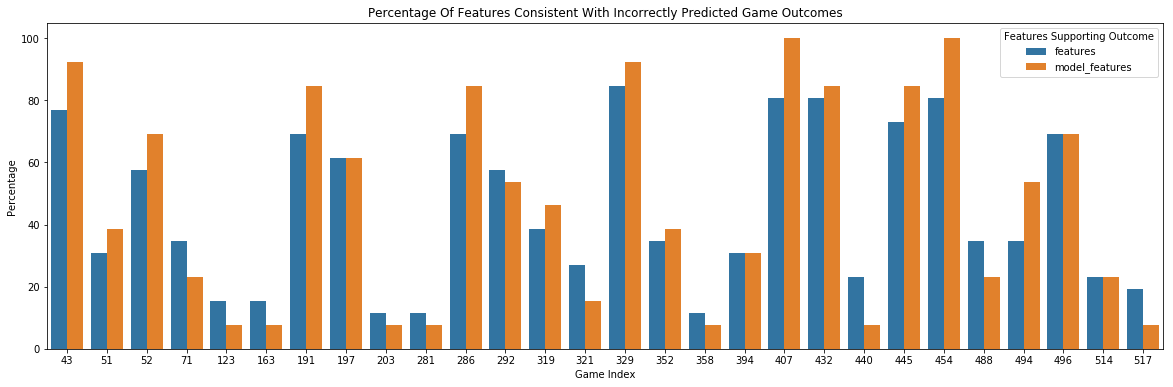

In [45]:
m_plot = sns.barplot(x='game_index', y='value', hue='Features Supporting Outcome', data= plot_missed_predictions_df) 
plt.title("Percentage Of Features Consistent With Incorrectly Predicted Game Outcomes")
plt.ylabel('Percentage')
plt.xlabel('Game Index')
m_plot.figure.set_size_inches(20,6)

#### The bar chart depicts the percentage of features that correctly corresponded to the game outcome but were out weighed by other features in predicting the game incorrectly. Games corresponding to bar heights exceeding 50% should be scrutinized.